In [ ]:
import pandas as pd
import numpy as np

# df_final = pd.read_csv('df_combined.csv')

### Feature generation

In [23]:
df_final['time'] = pd.to_datetime(df_final.index, utc=True)

print(df_final['time'].dtype)


datetime64[ns, UTC]


In [24]:
# df_final.set_index("time", inplace=True)

df_final['hour'] = df_final['time'].dt.hour
df_final['weekday'] = df_final['time'].dt.weekday
df_final['month'] = df_final['time'].dt.month 

In [25]:
# # Ensure 'hour' and 'weekday' columns are created
# df_final['hour'] = df_final['time'].dt.hour
# df_final['weekday'] = df_final['time'].dt.weekday

# Define conditions and values for 'business hour' and 'weekday_category' in one go

# Business hour conditions and values
business_conditions = [
    ((df_final['hour'] > 8) & (df_final['hour'] < 14)) | ((df_final['hour'] > 17) & (df_final['hour'] < 21)),
    (df_final['hour'] >= 14) & (df_final['hour'] <= 17)
]
business_values = [2, 1]

# Weekday category conditions and values
weekday_conditions = [
    (df_final['weekday'] == 6),  # Sunday
    (df_final['weekday'] == 5)   # Saturday
]
weekday_values = [2, 1]

print(df_final.columns)

# Assign 'business hour' and 'weekday_category' using np.select
df_final['business hour'] = np.select(business_conditions, business_values, default=0)
df_final['weekday_category'] = np.select(weekday_conditions, weekday_values, default=0)


Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_0', 'temp_min_0', 'temp_max_0',
       'pressure_0', 'humidity_0', 'wind_speed_0', 'wind_deg_0', 'rain_1h_0',
       'clouds_all_0', 'weather_id_0', 'temp_1', 'temp_min_1', 'temp_max_1',
       'pressure_1', 'humidity_1', 'wind_speed_1', 'wind_deg_1', 'rain_1h_1',
       'snow_3h_1', 'clouds_all_1', 'weather_id_1', 'temp_2', 'temp_min_2',
       'temp_max_2', 'pressure_2', 'humidity_2', 'wind_speed_2', 'wind_deg_2',
       'rain_1h_2', 'snow_3h_2', 'clouds_al

In [26]:
# Define the list of cities
# cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

population =  5179243 + 987000 + 6155116 + 1305342 + 1645342

weights = [
5179243 / population,
987000 / population,
6155116 / population,
1305342 / population,
1645342 / population
]
# Calculate the temperature range for each city in a vectorized way
for label in range(5):
    # Compute the absolute difference and store it in a new column
    df_final['temp_range_{}'.format(label)] = abs(df_final['temp_max_{}'.format(label)] - df_final['temp_min_{}'.format(label)])


cities_weights = {label: weight for label, weight in enumerate(weights)}

df_final['temp_weighted'] = sum(df_final[f'temp_{label}'] * weight for label, weight in enumerate(weights))



### Feature selection

In [27]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [28]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size


    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])

    return np.array(data), np.array(labels)

In [ ]:
# df_final.set_index('time', inplace=True)

# timestamp = pd.Timestamp('2018-01-01 00:00:00', tz='UTC')

# train_end_idx = df_final.index.get_loc(timestamp, method='nearest')
# print(df_final.index.get_loc(timestamp, method='nearest'))

# remaining_data = df_final.iloc[train_end_idx:]
# remaining_size = len(remaining_data)

# cv_end_idx = train_end_idx + remaining_size // 2
# test_end_idx = train_end_idx + remaining_size
# ds_size = len(df_final)
# train_ratio = 0.7
# cv_ratio = 0.2
# test_ratio = 0.1
# train_end_idx = int(train_ratio * ds_size)
# cv_end_idx = train_end_idx + int(cv_ratio * ds_size)
# test_end_idx = cv_end_idx + int(test_ratio * ds_size)

train_end_idx = 26307
# print(df_final.index[train_end_idx])

remaining_size = len(df_final) - train_end_idx

# Split the remaining data into two halves for cv and test sets
cv_end_idx = train_end_idx + remaining_size // 2
test_end_idx = len(df_final)

# Ensure that the indices do not exceed the dataset size (useful for edge cases)
cv_end_idx = min(cv_end_idx, len(df_final))
test_end_idx = min(test_end_idx, len(df_final))

26307


In [31]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Drop or convert any non-numeric columns in df_final
# Assuming 'time' is the column causing the issue, you may drop it here
X = df_final.drop(columns=['price actual', 'time'], errors='ignore').values  # Drop 'time' if it exists
y = df_final['price actual'].values

# Reshape y for scaling
y = y.reshape(-1, 1)

# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on the training set
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

# Confirm the columns in df_final after dropping any non-numeric columns
print("Columns in df_final after preprocessing:", df_final.columns)


Columns in df_final after preprocessing: Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_0', 'temp_min_0', 'temp_max_0',
       'pressure_0', 'humidity_0', 'wind_speed_0', 'wind_deg_0', 'rain_1h_0',
       'clouds_all_0', 'weather_id_0', 'temp_1', 'temp_min_1', 'temp_max_1',
       'pressure_1', 'humidity_1', 'wind_speed_1', 'wind_deg_1', 'rain_1h_1',
       'snow_3h_1', 'clouds_all_1', 'weather_id_1', 'temp_2', 'temp_min_2',
       'temp_max_2', 'pressure_2', 'humidity_2', 'wind_speed_2', 'wind_deg_2',
  

In [32]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [40]:
pca = PCA()
print(X_norm.shape)
X_pca = pca.fit_transform(X_norm[:train_end_idx])
X_pca.shape

(35064, 80)


(26307, 80)

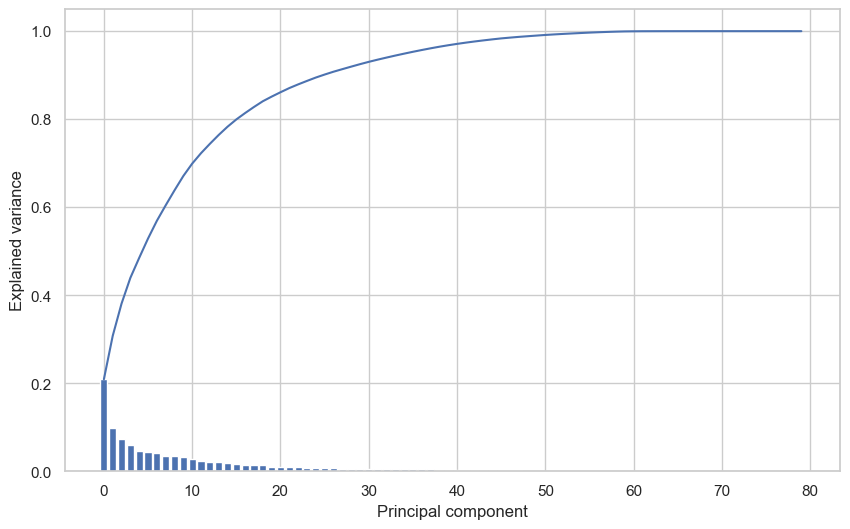

In [41]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [44]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [45]:
X_pca.shape

(35064, 17)

In [46]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0


In [47]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [48]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [49]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [50]:
batch_size = 32
buffer_size = 1000

In [51]:
import tensorflow as tf


train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [52]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [53]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

